In [19]:
import numpy as np
import pycyc
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl
from plotting import plot_intrinsic_vs_observed
import copy
import pickle
import importlib
import sys
import time

In [2]:
mpl.rcParams["image.aspect"] = "auto"

In [3]:
from scipy.fft import rfft, fft, fftshift, ifft, fftn, ifftn

CS = pycyc.CyclicSolver("P2067/chan07/53873.27864.07.15s.cyc", zap_edges = 0.05556, pscrunch=True)
CS.data.shape, CS.nspec

CS.load("P2067/chan07/53873.31676.07.15s.cyc")
CS.data.shape, CS.nspec

CS.save_cyclic_spectra = 0
CS.iprint = 0
CS.initProfile()

with open ("cs_post_init.pkl", "wb") as fh:
    pickle.dump(CS, fh)

In [ ]:
with open ("cs_post_init.pkl", "rb") as fh:
    CS = pickle.load(fh)

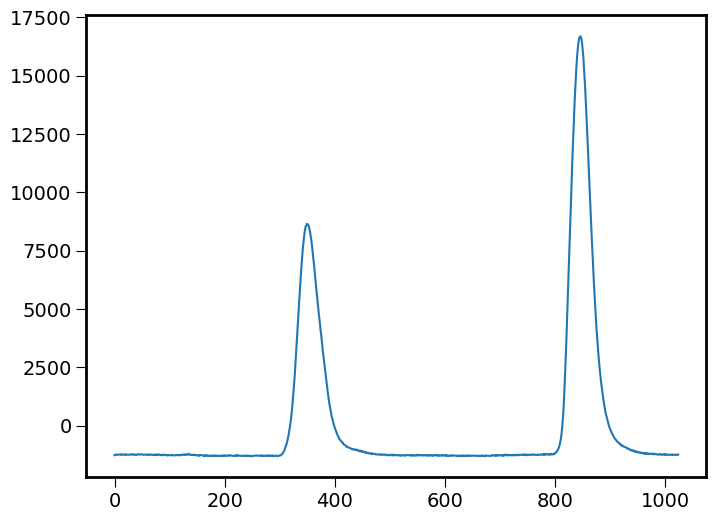

In [11]:
plt.plot(CS.pp_int)
pp_scattered = np.copy(CS.pp_ref)

In [32]:
# reload a module to incorporate code chanegs

if "pycyc" in sys.modules.keys():
    print("Updated pycyc")
    importlib.reload(sys.modules["pycyc"])
import pycyc

if "fista" in sys.modules.keys():
    print("Updated fista")
    importlib.reload(sys.modules["fista"])
import fista

Updated pycyc
Updated fista


In [16]:
# FISTA DA LOT!
CS.iprint = 0
CS.make_plots = 0
CS.niter = 0
CS.ml_profile = 0
CS.initWavefield()

y_n = np.copy(CS.h_doppler_delay)
x_n = np.copy(CS.h_doppler_delay)
t_n = 1

initial filter: isub=0/468 delay=4082
merit= 1.7320741e+06  grad= 4.2507292e+03
initial filter: isub=1/468 delay=4074
merit= 1.7694605e+06  grad= 4.1576593e+03
initial filter: isub=2/468 delay=4088
merit= 1.9151450e+06  grad= 4.1056211e+03
initial filter: isub=3/468 delay=4093
merit= 2.1224571e+06  grad= 4.1063021e+03
initial filter: isub=4/468 delay=4069
merit= 2.0587009e+06  grad= 3.9933549e+03
initial filter: isub=5/468 delay=6
merit= 2.0711052e+06  grad= 4.0259571e+03
initial filter: isub=6/468 delay=5
merit= 2.3558922e+06  grad= 4.2588720e+03
initial filter: isub=7/468 delay=7
merit= 2.2563563e+06  grad= 4.3655436e+03
initial filter: isub=8/468 delay=4077
merit= 2.0360550e+06  grad= 4.3866902e+03
initial filter: isub=9/468 delay=25
merit= 2.2104188e+06  grad= 4.5807304e+03
initial filter: isub=10/468 delay=4
merit= 1.9460381e+06  grad= 4.5540934e+03
initial filter: isub=11/468 delay=4093
merit= 1.9911277e+06  grad= 4.4812292e+03
initial filter: isub=12/468 delay=14
merit= 2.018051

merit= 1.7257264e+06  grad= 4.3888529e+03
initial filter: isub=104/468 delay=4072
merit= 1.6233279e+06  grad= 4.3875327e+03
initial filter: isub=105/468 delay=4089
merit= 1.5462632e+06  grad= 4.3765685e+03
initial filter: isub=106/468 delay=4078
merit= 1.6459810e+06  grad= 4.3809190e+03
initial filter: isub=107/468 delay=4092
merit= 1.6643201e+06  grad= 4.4192838e+03
initial filter: isub=108/468 delay=2
merit= 1.6159459e+06  grad= 4.4300002e+03
initial filter: isub=109/468 delay=1
merit= 1.5934310e+06  grad= 4.5357271e+03
initial filter: isub=110/468 delay=31
merit= 1.6355894e+06  grad= 4.5960961e+03
initial filter: isub=111/468 delay=4079
merit= 1.6793617e+06  grad= 4.5900821e+03
initial filter: isub=112/468 delay=15
merit= 1.7312035e+06  grad= 4.4360227e+03
initial filter: isub=113/468 delay=4093
merit= 1.8849443e+06  grad= 4.3719375e+03
initial filter: isub=114/468 delay=19
merit= 2.0007279e+06  grad= 4.3048118e+03
initial filter: isub=115/468 delay=4078
merit= 2.1051695e+06  grad= 

merit= 1.4249761e+06  grad= 4.6633011e+03
initial filter: isub=206/468 delay=4081
merit= 1.4966632e+06  grad= 4.7013368e+03
initial filter: isub=207/468 delay=8
merit= 1.5195536e+06  grad= 4.7108452e+03
initial filter: isub=208/468 delay=4
merit= 1.6746634e+06  grad= 4.6888245e+03
initial filter: isub=209/468 delay=4091
merit= 1.7559100e+06  grad= 4.5903876e+03
initial filter: isub=210/468 delay=31
merit= 1.6411161e+06  grad= 4.3483480e+03
initial filter: isub=211/468 delay=14
merit= 1.7046815e+06  grad= 4.2367893e+03
initial filter: isub=212/468 delay=27
merit= 1.7560781e+06  grad= 4.2563706e+03
initial filter: isub=213/468 delay=26
merit= 1.5340476e+06  grad= 4.2238280e+03
initial filter: isub=214/468 delay=8
merit= 1.6061018e+06  grad= 4.3084338e+03
initial filter: isub=215/468 delay=9
merit= 1.5785169e+06  grad= 4.2832489e+03
initial filter: isub=216/468 delay=4089
merit= 1.6543815e+06  grad= 4.2347380e+03
initial filter: isub=217/468 delay=4070
merit= 1.6287731e+06  grad= 4.110862

merit= 1.6505915e+06  grad= 4.6828872e+03
initial filter: isub=308/468 delay=24
merit= 1.6507798e+06  grad= 4.7347461e+03
initial filter: isub=309/468 delay=1
merit= 1.7683437e+06  grad= 4.7851452e+03
initial filter: isub=310/468 delay=4090
merit= 1.8829182e+06  grad= 4.6952418e+03
initial filter: isub=311/468 delay=36
merit= 1.8622235e+06  grad= 4.4268220e+03
initial filter: isub=312/468 delay=0
merit= 1.9137442e+06  grad= 4.1925696e+03
initial filter: isub=313/468 delay=4085
merit= 2.0539923e+06  grad= 4.0115316e+03
initial filter: isub=314/468 delay=0
merit= 2.1564350e+06  grad= 3.8730633e+03
initial filter: isub=315/468 delay=6
merit= 2.2980806e+06  grad= 3.8463866e+03
initial filter: isub=316/468 delay=23
merit= 2.2213056e+06  grad= 3.8817182e+03
initial filter: isub=317/468 delay=4074
merit= 2.4553827e+06  grad= 4.0748894e+03
initial filter: isub=318/468 delay=7
merit= 2.2597024e+06  grad= 4.2266395e+03
initial filter: isub=319/468 delay=15
merit= 2.2248537e+06  grad= 4.4576721e+

merit= 1.9075921e+06  grad= 4.7796709e+03
initial filter: isub=410/468 delay=20
merit= 2.1006109e+06  grad= 4.7633170e+03
initial filter: isub=411/468 delay=4092
merit= 2.2312777e+06  grad= 4.6689544e+03
initial filter: isub=412/468 delay=1
merit= 2.4493587e+06  grad= 4.4703180e+03
initial filter: isub=413/468 delay=4066
merit= 2.6618158e+06  grad= 4.2262824e+03
initial filter: isub=414/468 delay=4092
merit= 2.3352015e+06  grad= 3.9427295e+03
initial filter: isub=415/468 delay=4068
merit= 2.4141775e+06  grad= 3.9979787e+03
initial filter: isub=416/468 delay=9
merit= 2.3865218e+06  grad= 4.1819873e+03
initial filter: isub=417/468 delay=29
merit= 2.1859802e+06  grad= 4.3936981e+03
initial filter: isub=418/468 delay=4090
merit= 2.1511883e+06  grad= 4.5927217e+03
initial filter: isub=419/468 delay=20
merit= 2.1148960e+06  grad= 4.7241368e+03
initial filter: isub=420/468 delay=4076
merit= 2.1374124e+06  grad= 4.8324898e+03
initial filter: isub=421/468 delay=27
merit= 2.1987785e+06  grad= 4.

In [17]:
CS.iprint = 0
best_merit = CS.merit
best_x = np.copy(x_n)

demerits = np.array([])
alpha = 10.0

print(f"starting merit={best_merit}")

starting merit=876772807.3543491


In [31]:
alpha=6.4

2023-04-22 00:56:00,846 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 958464 non-zero elements with demerit 7.94e+08

demerit=793860878.5413353 alpha=13.075731488903454 t_n=2.749791340120445
Elapsed time: 9.981871680418651 min


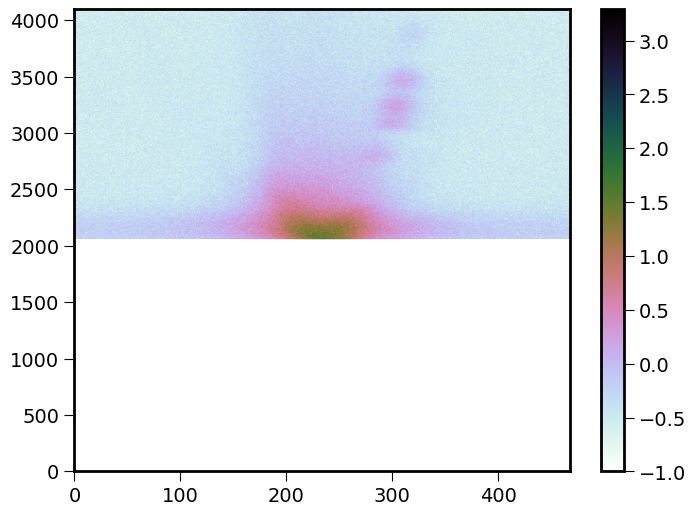

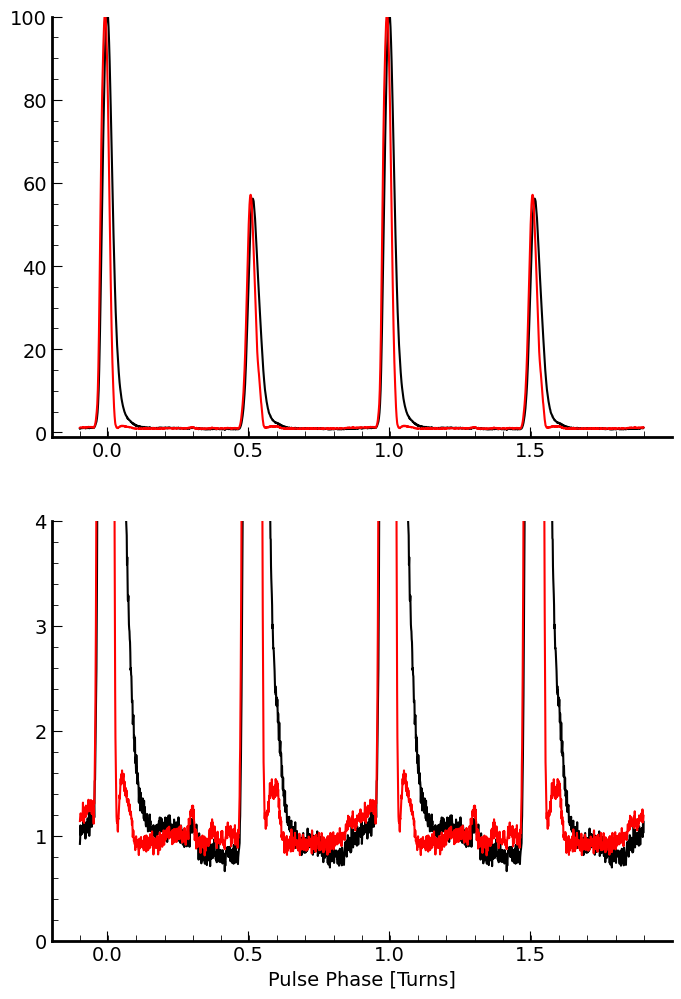

In [ ]:
# Start timer
start_time = time.time()

for i in range (1000):
    
    CS.nopt += 1
            
    x_n, y_n, L, t_n, demerits = fista.take_fista_step(iter=i, func=CS, 
        backtrack=False, alpha=alpha, 
        eta=5, y_n=y_n, _lambda=None,
        delay_for_inf=-int(CS.nchan/2), 
        zero_penalty_coords = np.array([]),
        fix_phase_value = None,
        fix_phase_coords = None,
        fix_support= np.array([]),
        t_n=t_n,
        x_n=x_n,
        demerits = demerits,
        eps = None,
    )

    alpha = 1.0 / L

    if CS.merit < best_merit:
        best_merit = CS.merit
        best_x = np.copy(x_n)
    else:
        print (f"**** greater than best={best_merit}")
        x_n = np.copy(best_x)
        y_n = np.copy(best_x)
        t_n = 1
            
    print(f"\ndemerit={CS.merit} alpha={alpha} t_n={t_n}")
    end_time = time.time()

    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time/60} min") 

    if i % 10 == 0:
        plotthis = np.log10(np.abs(fftshift(x_n))+ 1e-2)
        plt.imshow(plotthis.T, aspect="auto", origin="lower", cmap="cubehelix_r", vmin=-1)
        plt.colorbar()
        plt.show()
        plot_intrinsic_vs_observed(CS, pp_scattered)
        plt.show()
    

In [29]:
x_n = np.copy(best_x)
y_n = np.copy(best_x)
t_n = 1